In [1]:
# %%
import scanpy as sc
import pandas as pd

# 📥 Load raw counts (cells × genes) from .h5ad
adata_raw = sc.read("../../data/pancancer_raw_umi_filtered.h5ad")

# Convert .X to DataFrame
umi_df = pd.DataFrame(
    adata_raw.X,
    index=adata_raw.obs_names,
    columns=adata_raw.var_names,
)
print("✅ Loaded raw UMI counts:", umi_df.shape)

# 📥 Load scran-normalized (cells × genes) from .parquet
scran_df = pd.read_parquet("../../data/processed/pancancer_scran_norm.parquet")
print("✅ Loaded scran-normalized:", scran_df.shape)


✅ Loaded raw UMI counts: (39726, 30314)
✅ Loaded scran-normalized: (39726, 30314)


In [2]:
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

# Enable pandas-to-R conversion
pandas2ri.activate()

# Transpose (genes × cells)
raw_counts = umi_df.T

# Wrap in DataFrame explicitly (ensures conversion works)
raw_counts_df = pd.DataFrame(raw_counts)

# Send to R
ro.globalenv["raw_counts"] = raw_counts_df
ro.globalenv["gene_names"] = raw_counts.index.to_list()
ro.globalenv["cell_names"] = raw_counts.columns.to_list()

print("✅ Sent raw_counts, gene_names, cell_names to R")


✅ Sent raw_counts, gene_names, cell_names to R


In [3]:
%load_ext rpy2.ipython


In [4]:
%%R
library(scry)
library(SingleCellExperiment)

sce <- SingleCellExperiment(list(counts = raw_counts))
rownames(sce) <- gene_names
colnames(sce) <- cell_names

sce <- devianceFeatureSelection(sce)
binomial_deviance <- rowData(sce)$binomial_deviance


R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: MatrixGenerics

R[write to console]: Loading required package: matrixStats

R[write to console]: 
Attaching package: ‘MatrixGenerics’


R[write to console]: The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiff

In [8]:
import numpy as np

binomial_deviance = np.array(ro.r("binomial_deviance"))
idx = binomial_deviance.argsort()[-2000:]

top_genes = raw_counts.index[idx]
print("✅ Selected top 4000 deviant genes")

# Save for later use
#pd.Series(top_genes).to_csv("../../data/processed/top4000_deviant_genes.txt", index=False)


✅ Selected top 4000 deviant genes


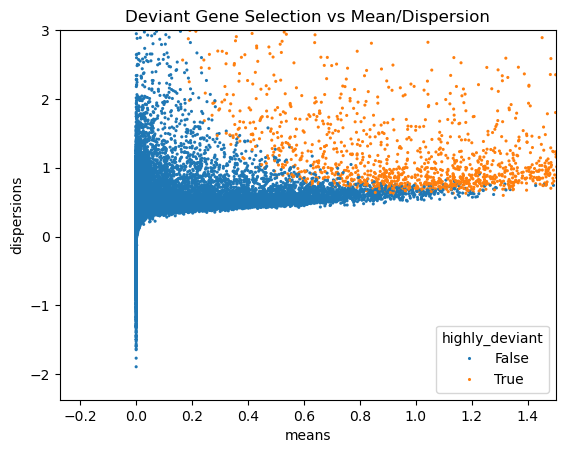

In [9]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

# Recreate AnnData only for plotting
import scipy.sparse as sp
adata = sc.AnnData(X=sp.csr_matrix(scran_df.values))
adata.var_names = scran_df.columns
adata.obs_names = scran_df.index

# Run HVG on scran-normalized values
sc.pp.highly_variable_genes(adata)

adata.var["highly_deviant"] = adata.var_names.isin(top_genes)

# Plot mean vs dispersion
ax = sns.scatterplot(
    data=adata.var,
    x="means", y="dispersions",
    hue="highly_deviant", s=5, linewidth=0
)
ax.set_xlim(None, 1.5)
ax.set_ylim(None, 3)
plt.title("Deviant Gene Selection vs Mean/Dispersion")
plt.show()


In [10]:
# Filter scran-normalized data to top 4000 deviant genes
scran_top4k = scran_df.loc[:, top_genes]

scran_top4k.to_parquet("../../data/processed/pancancer_scran_norm_top2000.parquet",
                       engine="pyarrow", compression="snappy")

print("💾 Saved scran-normalized top 8000 genes:", scran_top4k.shape)


💾 Saved scran-normalized top 8000 genes: (39726, 2000)
